## Summary

This tutorial uses napari 0.4.15.<br>

Dataset:<br>
FISH in C. elegans
Voxel dimensions: 0.162x0.162x0.200 um

Analysis goals:<br> 
- Centroid location in microns (um) for each spot
- Integrated Intensity

Tutorial goals:<br>
(1) Use napari + Python libraries to perform common image analysis from end to end.<br>
(2) Note napari viewer GUI/API function availability at varioius steps.  

Steps:
- Load image
- Crop image (to speed up testing)
- Remove background
- Remove noise
- Points detection
- Output centroid location in microns
- Output center intensity
- Output integrated intensity?

Additional resources:
https://haesleinhuepf.github.io/BioImageAnalysisNotebooks/intro.html

Related issues:

Acknowledgement: 
Andy Sweet, Nick Sofroniew

<font color=red> RED: links to add<br> </font>
<font color=blue> BLUE: GUI availability in viewer </font>

## Load Image

Images are in tiff format, can be opened by napari without additional reader plugins.
Images saved locally in the folder '/Users/cchiu/Desktop/images/ABRF/FISH/'

In [62]:
from os import listdir
from os.path import isfile, join
mypath = '/Users/cchiu/Desktop/images/ABRF/FISH/'
files = [join(mypath, f) for f in listdir(mypath)]
print(files)

['/Users/cchiu/Desktop/images/ABRF/FISH/fish4_celegans_dyn-10_ceff-90_final.ics.ome.tiff', '/Users/cchiu/Desktop/images/ABRF/FISH/.DS_Store', '/Users/cchiu/Desktop/images/ABRF/FISH/fish2_celegans_dyn-90_ceff-90_final.ics.ome.tiff', '/Users/cchiu/Desktop/images/ABRF/FISH/fish1_celegans_dyn-90_ceff-0_final.ics.ome.tiff', '/Users/cchiu/Desktop/images/ABRF/FISH/fish3_celegans_dyn-10_ceff-0_final.ics.ome.tiff']


In [63]:
import napari
from napari.utils import nbscreenshot
from tifffile import imread

#file2 = '/Users/cchiu/Desktop/images/ABRF/nuclei/nuclei1_out_c00_dr90_image.tiff'
#file1 = '/Users/cchiu/Desktop/images/ABRF/FISH/fish1_celegans_dyn-90_ceff-0_final.ics.ome.tiff'

fish1 = imread(files[3])
print(files[3])
#crop the image for faster processing
fish1 = fish1[40:50,100:300,100:300]

viewer = napari.view_image(fish1, name='original')
viewer.dims.ndisplay = 3
print("file dimension: (z,y,x)",viewer.layers['original'].data.shape)

/Users/cchiu/Desktop/images/ABRF/FISH/fish1_celegans_dyn-90_ceff-0_final.ics.ome.tiff


/opt/anaconda3/envs/napari-blob/lib/python3.10/site-packages/napari_tools_menu/__init__.py:165: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


file dimension: (z,y,x) (10, 200, 200)


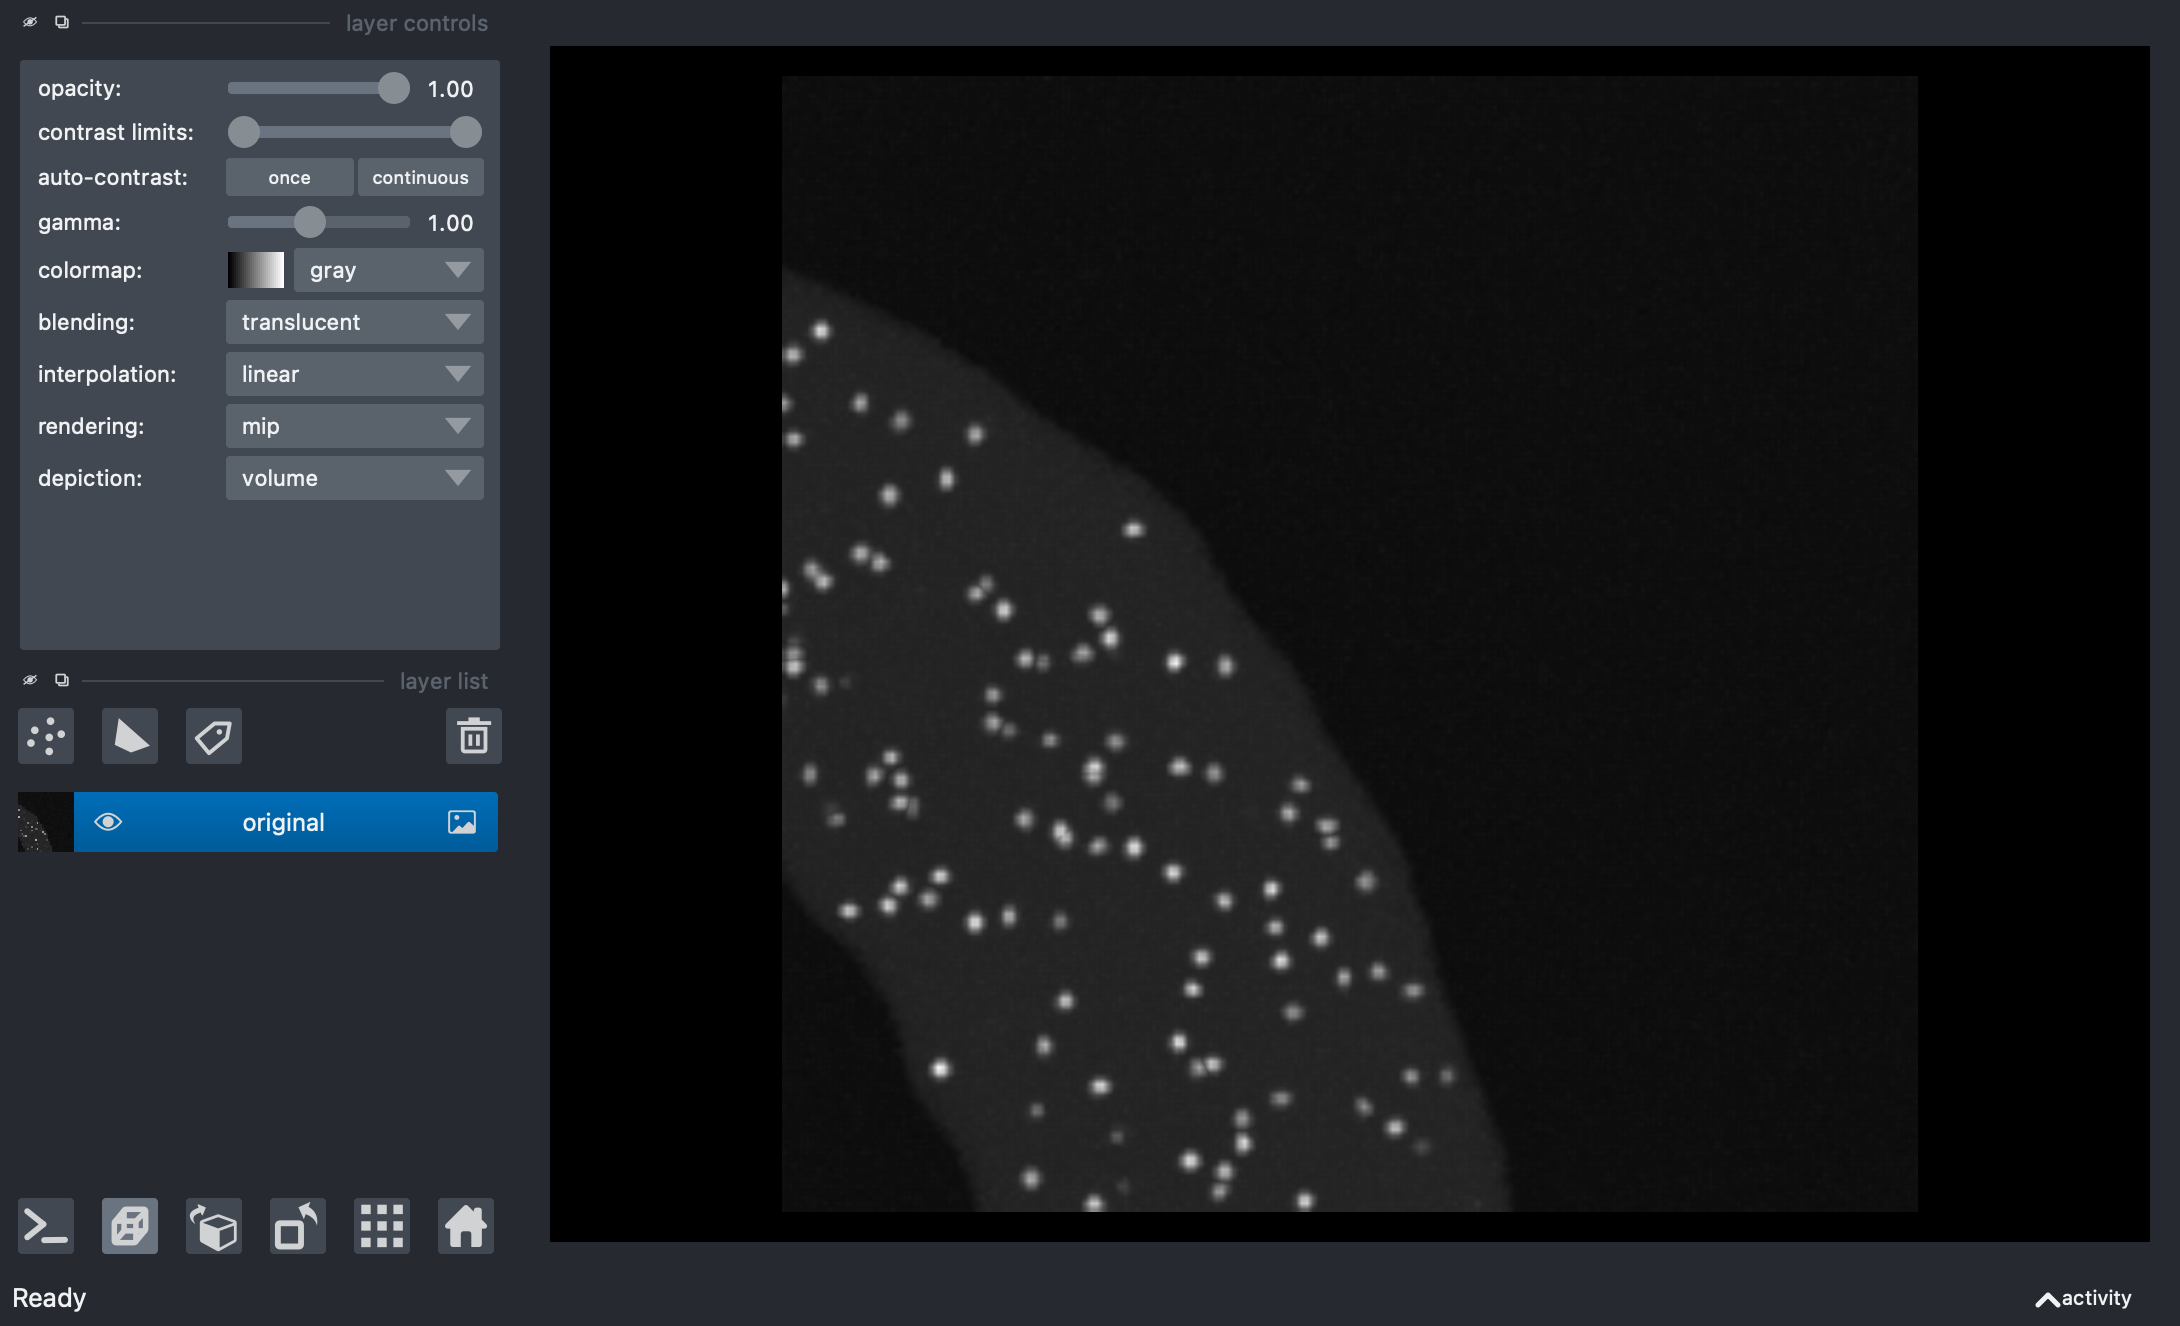

In [64]:
nbscreenshot(viewer)

## Remove background
Use skimage.morphology.white_tophat

The white top hat of an image is defined as the image minus its morphological opening. This operation returns the bright spots of the image that are smaller than the footprint.

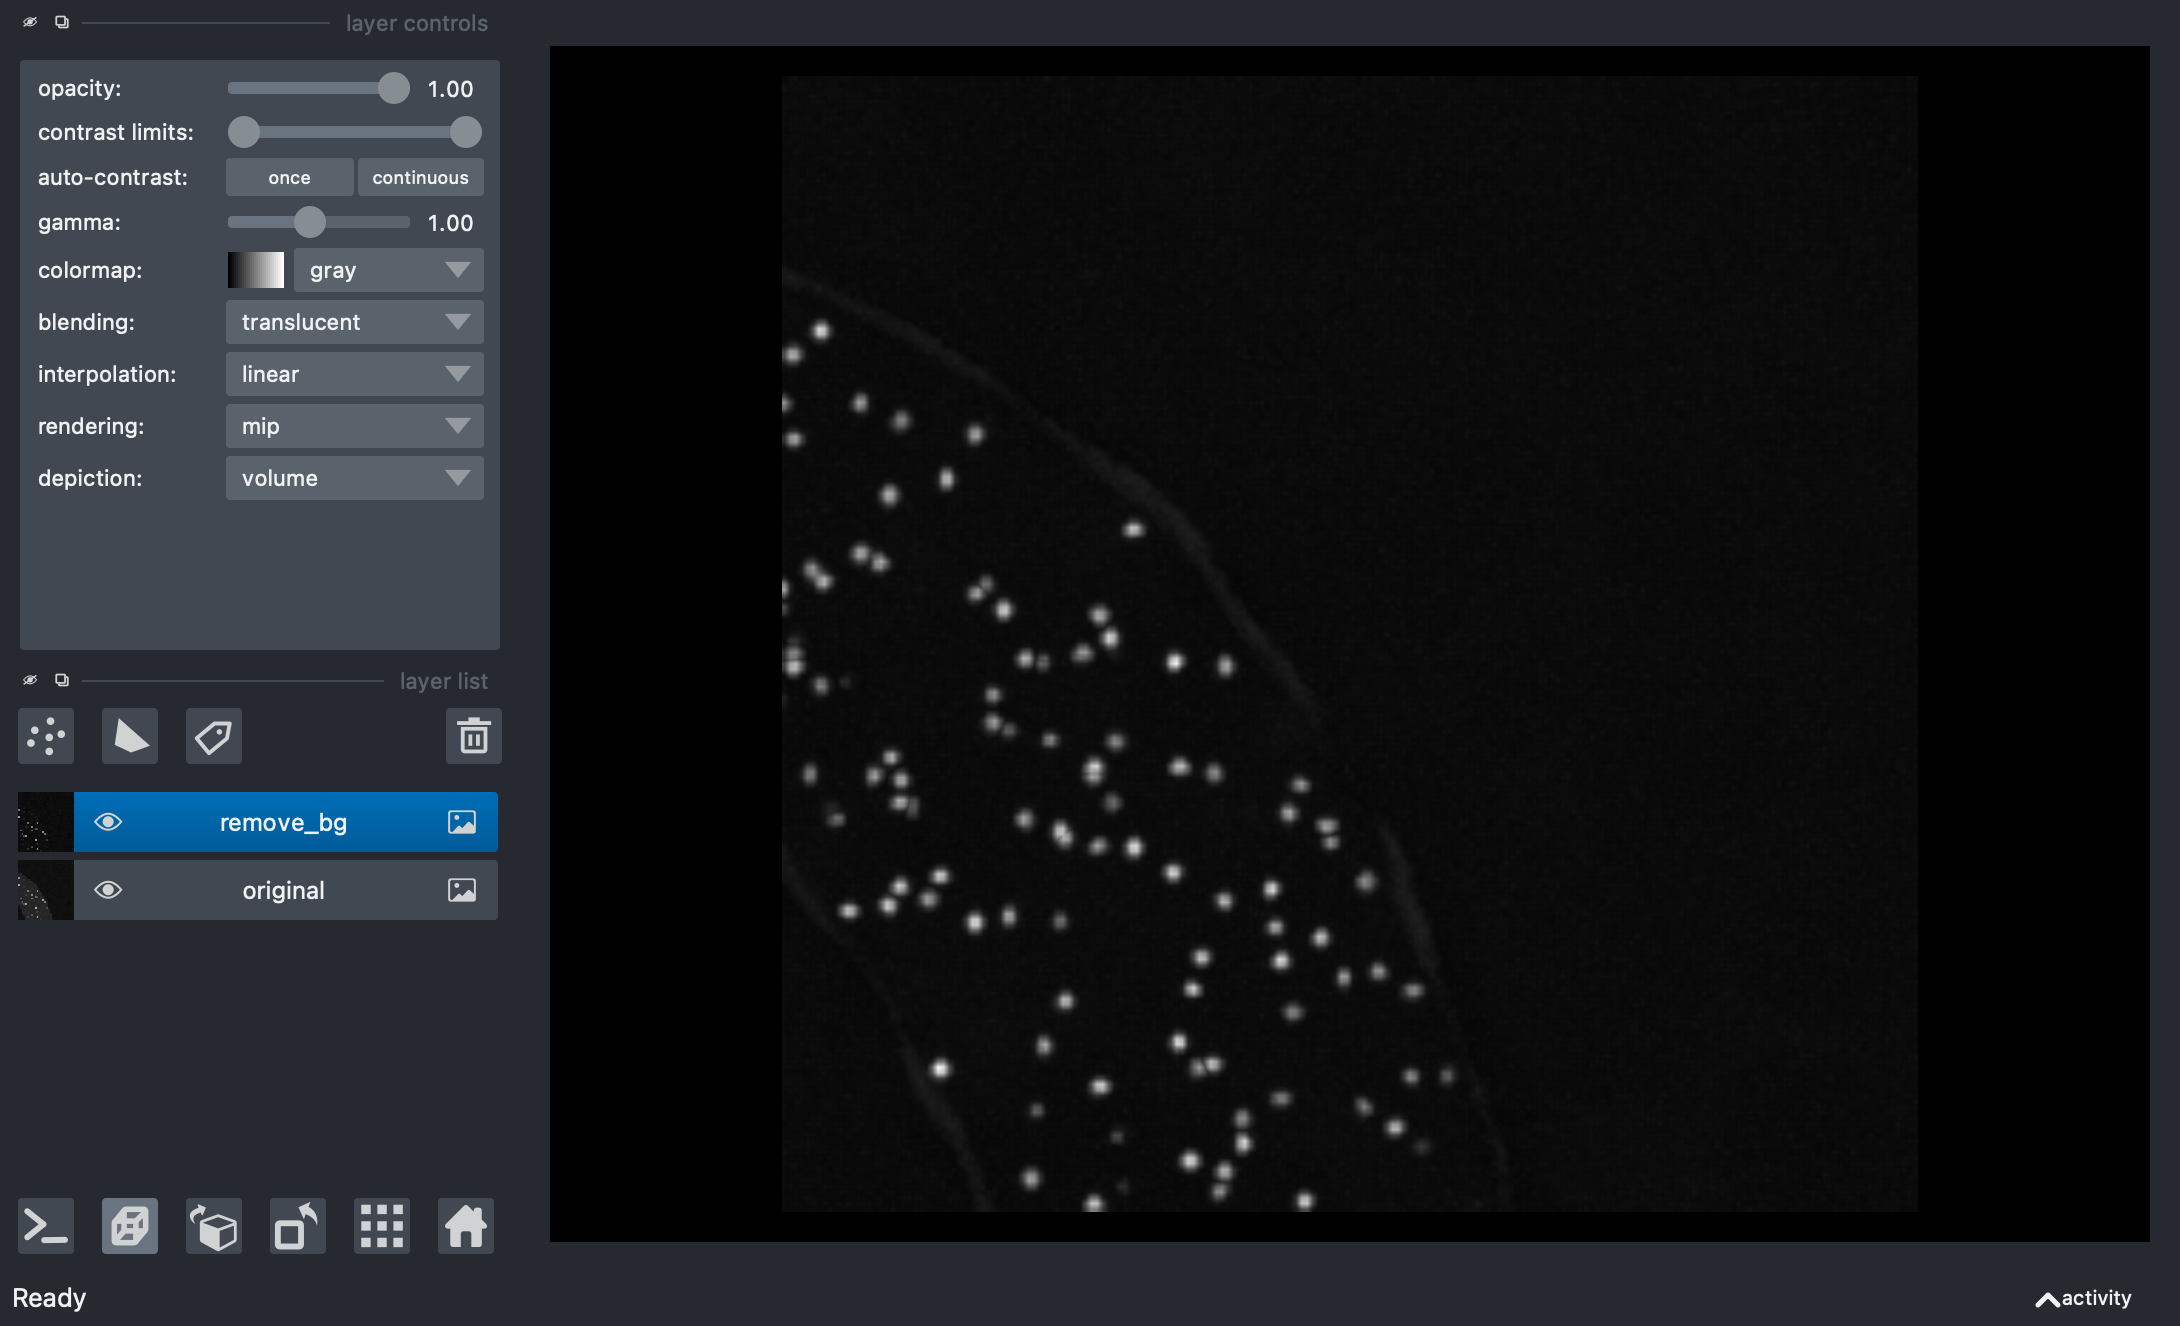

In [65]:
from skimage.morphology import white_tophat, ball
bg_subtracted_image = white_tophat(fish1, ball(10))

viewer.add_image(bg_subtracted_image, name='remove_bg')
nbscreenshot(viewer)

## Remove noise
Use skimage.filters.median

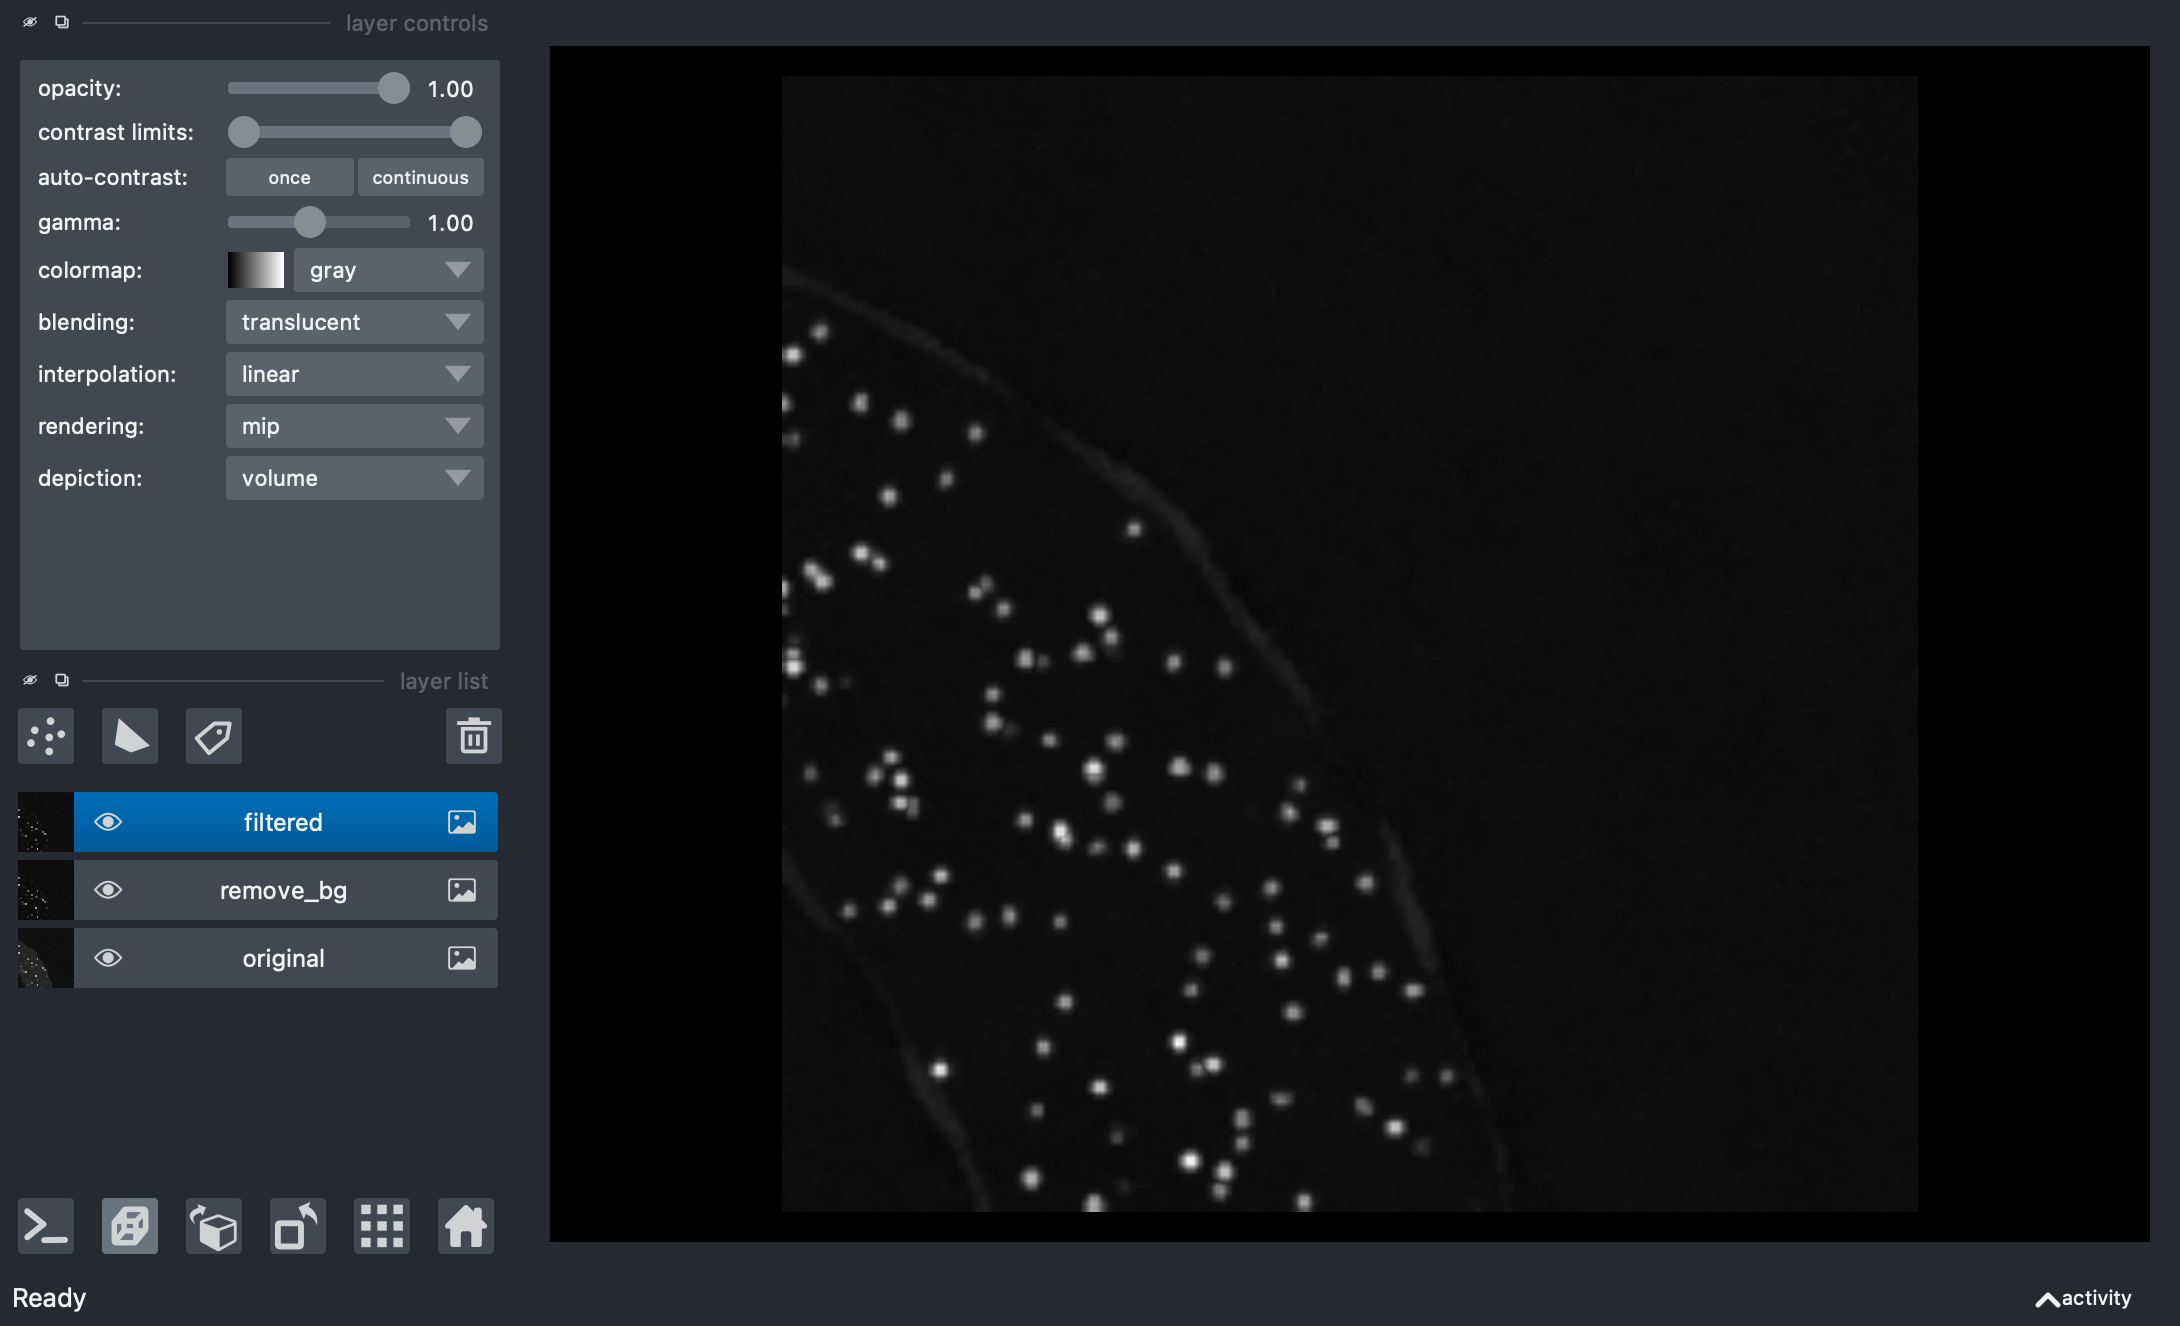

In [66]:
from skimage.filters import median
median_filtered = median(bg_subtracted_image,ball(1))
viewer.add_image(median_filtered, name='filtered')
nbscreenshot(viewer)

## Points detection

(1) Use skimage.feature.blob_log to detect points in membrane channel <br>
(2) Add points layer named "FISH" <br>

parameter note:
- min_sigma=1, max_sigma=5
- under-estimate the point size, why? 

- threshold = 0.05 for fish1/2 (high SNR)
- threshold = 0.01 for file3/4 (low SNR)

In [67]:
from skimage.feature import blob_log, blob_dog
import numpy as np
import time

#measure time
start_time = time.time()

blobs = blob_log(median_filtered, min_sigma=1, max_sigma=5,threshold=0.01)
print("--- %s seconds for log---" % (time.time() - start_time))

start_time = time.time()

blobs2 = blob_dog(median_filtered, min_sigma=1, max_sigma=5,threshold=0.01)
print("--- %s seconds for dog---" % (time.time() - start_time))

#returns coordinates + sigma, only keep coordinates
points = blobs[:,:-1]
points2 = blobs2[:,:-1]

#add point size
all_sigmas = blobs[:,-1]
all_sigmas2 = blobs2[:,-1]

viewer.add_points(points, 
        name='FISH', 
        size=np.sqrt(3)*np.array(all_sigmas),
        face_color='red',
        opacity=0.5,
        features={'sigma': all_sigmas})

viewer.add_points(points2, 
        name='FISH_dog', 
        size=np.sqrt(3)*np.array(all_sigmas2),
        face_color='green',
        opacity=0.5,
        features={'sigma': all_sigmas2})

print("total points detected with log:", points.shape[0])
print("total points detected with dog:", points2.shape[0])
print("min point size with log:", np.sqrt(3)*min(all_sigmas))
print("max point size with log:", np.sqrt(3)*max(all_sigmas))
print("min point size with dog:", np.sqrt(3)*min(all_sigmas2))
print("max point size with dog:", np.sqrt(3)*max(all_sigmas2))

--- 0.5467226505279541 seconds for log---
--- 0.1497511863708496 seconds for dog---
total points detected with log: 147
total points detected with dog: 138
min point size with log: 1.7320508075688772
max point size with log: 3.271651525407879
min point size with dog: 1.7320508075688772
max point size with dog: 2.7712812921102037


/opt/anaconda3/envs/napari-blob/lib/python3.10/site-packages/numpy/core/numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
/opt/anaconda3/envs/napari-blob/lib/python3.10/site-packages/numpy/core/numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


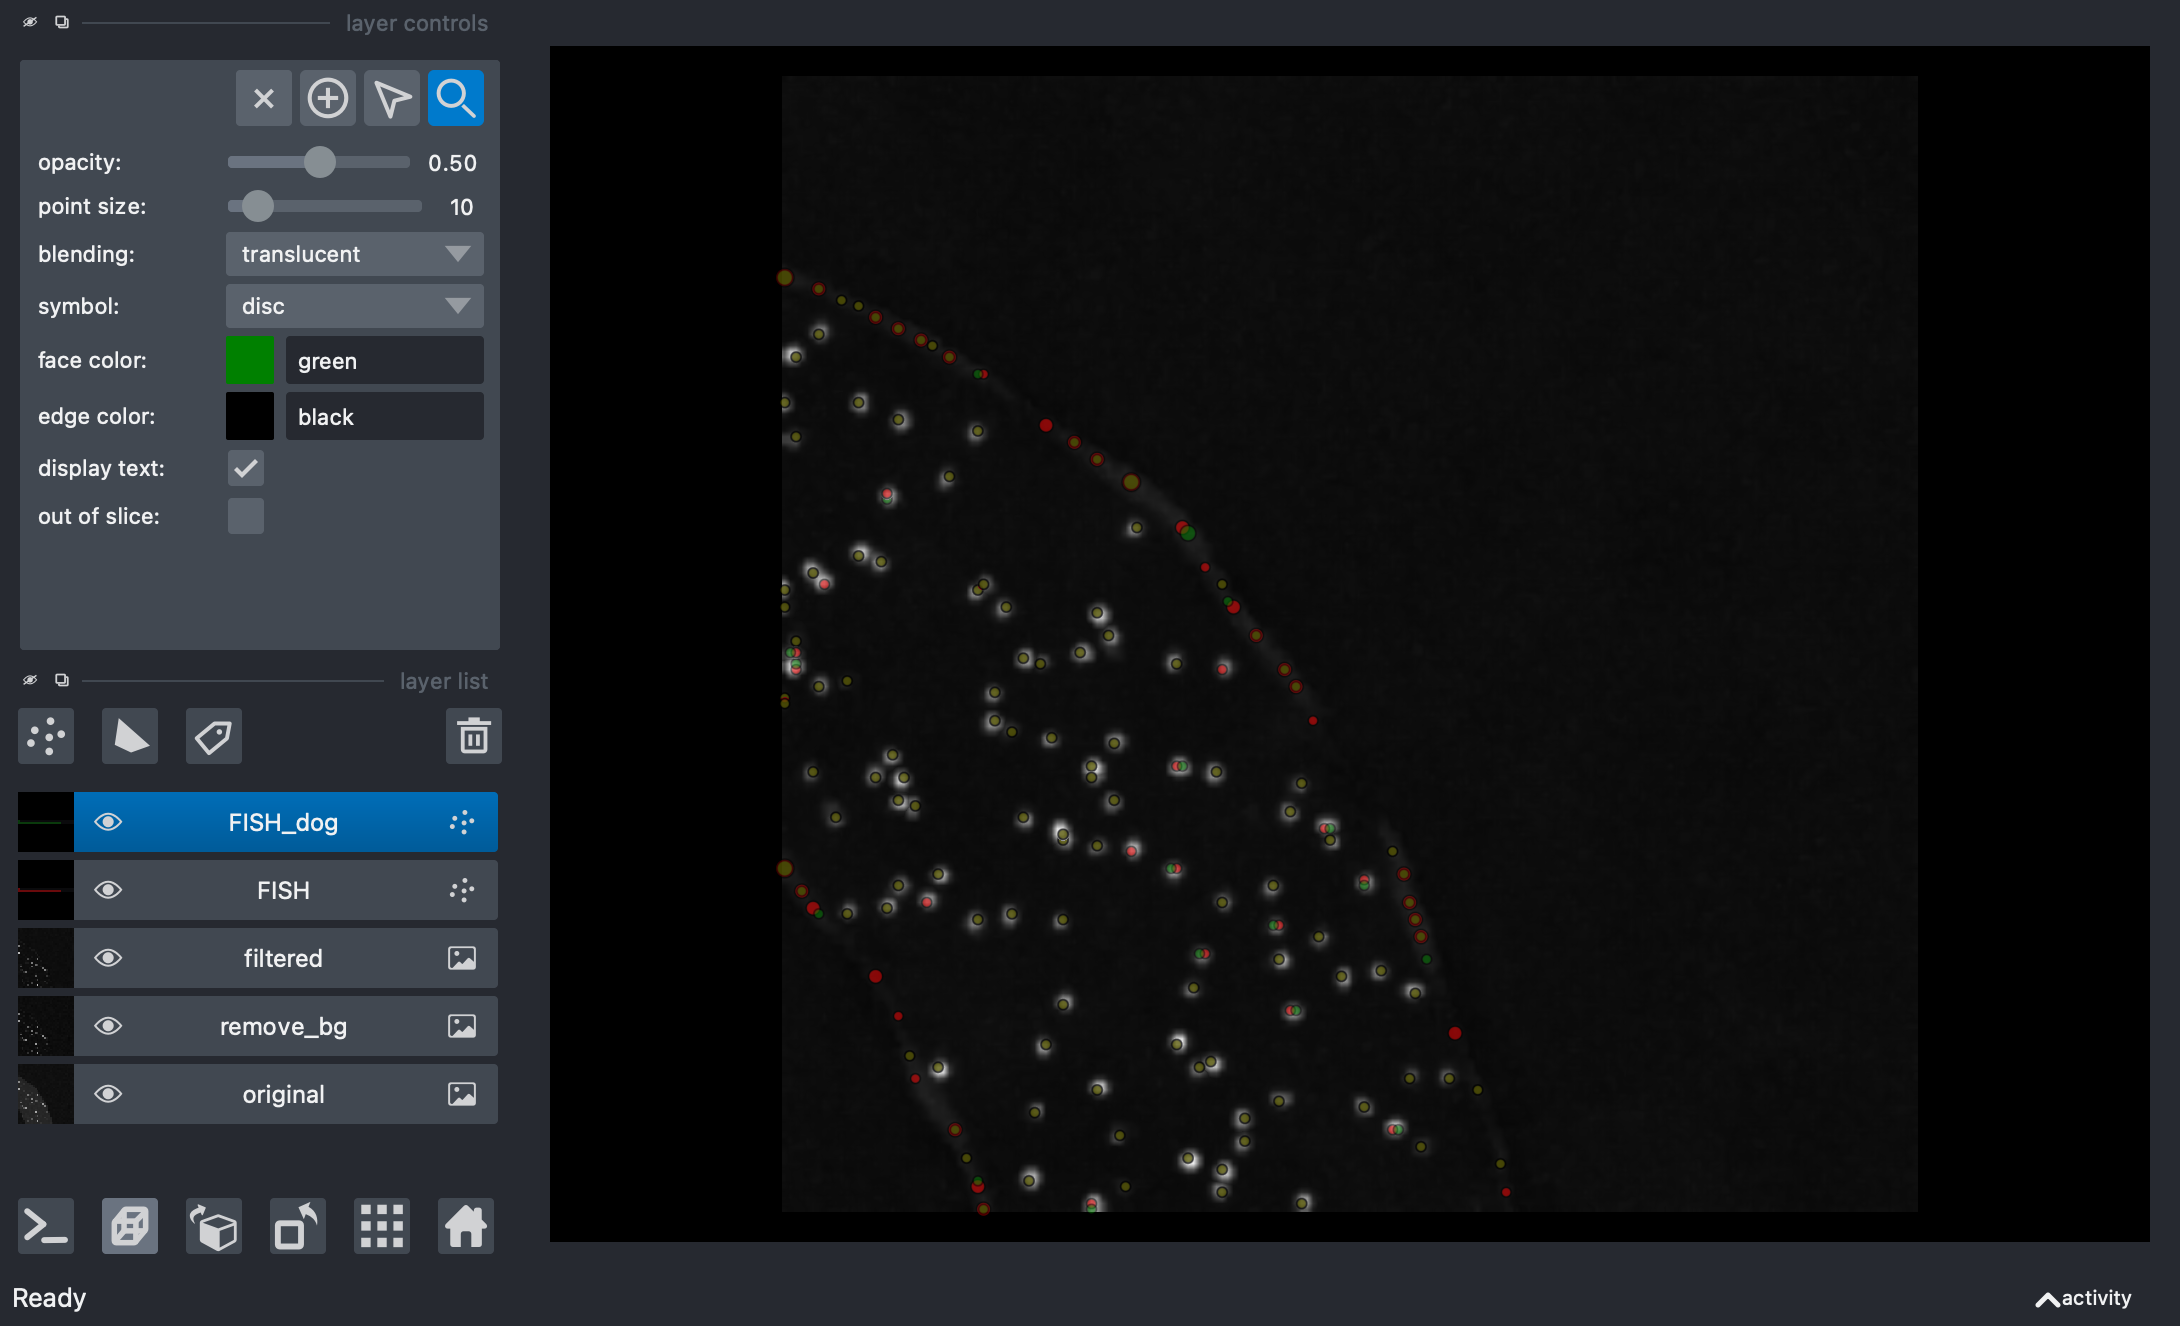

In [69]:
nbscreenshot(viewer)

## Output centroid location in um


In [70]:
import pandas as pd

pixel_size = np.array([0.2,0.162,0.162])
original = viewer.layers['FISH'].data
scaled = original*pixel_size

pd.DataFrame(original).to_csv('/Users/cchiu/Desktop/images/ABRF/result/original.csv')
pd.DataFrame(scaled).to_csv('/Users/cchiu/Desktop/images/ABRF/result/scaled.csv')

## Output intensity (1)
(1) Convert points to binary mask <br>
(2) Mask to labels <br>
(3) Use regionprops to extract centroid and intensity <br>

In [71]:
# points to labels
from skimage.morphology import label
mask = viewer.layers['FISH'].to_mask(shape=viewer.layers['original'].data.shape)
viewer.add_labels(label(mask), name='FISH_label')

from skimage.measure import regionprops_table

properties = ['centroid', 'intensity_mean', 'area']

cell_table = pd.DataFrame(
    regionprops_table(viewer.layers['FISH_label'].data, 
    intensity_image=viewer.layers['original'].data,
    properties=properties)
    )
display(cell_table)

centroid-0  centroid-1  centroid-2  intensity_mean  area
0      0.400000        35.0         0.4     8249.500000    10
1      0.166667        37.0         6.0     8650.333333     6
2      0.000000        39.0        10.0     8859.000000     1
3      0.000000        40.0        13.0     8542.000000     1
4      0.166667        42.0        16.0     8596.333333     6
..          ...         ...         ...             ...   ...
139    9.000000       183.0        81.0    33654.000000     1
140    9.000000       185.0       107.0    41100.000000     1
141    9.000000       186.0        59.0    21357.000000     1
142    9.000000       195.0        60.0    15824.000000     1
143    9.000000       198.0        54.0    44007.000000     1

[144 rows x 5 columns]

## Ouput intensity (2)
Directly get intensity from points.

In [72]:
intensity = np.zeros(viewer.layers['FISH'].data.shape[0])
i = 0

for z,y,x in viewer.layers['FISH'].data:
    intensity[i] = viewer.layers['original'].data[int(z),int(y),int(x)]
    i+=1

viewer.layers['FISH'].features['intensity'] = intensity

[46660. 46370. 42275. 43179. 40806. 54998. 41100. 38035. 37785. 36836.
 39909. 42691. 36624. 37667. 37705. 38562. 35422. 41420. 33758. 36828.
 40314. 37878. 45889. 40026. 41579. 34046. 49560. 41858. 44007. 37471.
 37822. 36294. 39371. 37794. 36788. 32661. 31774. 46057. 39936. 30891.
 43956. 36311. 33513. 39671. 30909. 54335. 44804. 33654. 34536. 38358.
 38198. 35783. 29895. 42147. 34787. 49448. 35326. 36459. 30923. 44834.
 29343. 46327. 35749. 34296. 38091. 29562. 44919. 30490. 34755. 39899.
 28334. 36203. 45967. 47330. 48730. 32685. 32519. 37270. 26784. 29273.
 41665. 45541. 35072. 39516. 42460. 23859. 25896. 37238. 29345. 25233.
 31023. 28322. 38606. 34318. 26807. 21757. 21357. 24592. 18646. 18395.
 15646. 15824. 13303.  8960.  9777. 10160.  9899.  9577.  9962.  8949.
  9860.  9103.  8855. 12983.  9326.  8330.  9354.  9547.  9907.  9146.
  8629.  9560.  9294.  9329.  9726.  8490.  8890.  8446.  9092.  9072.
  8542.  9771.  8978.  9271.  9167. 10308.  8769.  8859.  8634. 10088.
  8920

In [81]:
intensity_table = pd.DataFrame(
    viewer.layers['FISH'].data,
    viewer.layers['FISH'].features['intensity']
)
display(intensity_table)

0      1      2
intensity                   
46660.0    0.0  170.0   69.0
46370.0    0.0  190.0   71.0
42275.0    9.0  121.0   54.0
43179.0    0.0  133.0   49.0
40806.0    9.0  104.0    2.0
...        ...    ...    ...
8031.0     1.0  196.0  127.0
8168.0     0.0  158.0   16.0
8974.0     0.0   61.0   46.0
9212.0     0.0  113.0   93.0
9002.0     0.0  168.0  118.0

[147 rows x 3 columns]

## Alternatively, apply image segmentation and bypass Points layer

This method works fine with high SNR images (0,1,2) but fails with low SNR images (3)

In [79]:
from skimage.filters import threshold_otsu
thresh = threshold_otsu(median_filtered)
binary = median_filtered > thresh

from skimage.measure import label
seg = label(binary)
viewer.add_labels(seg, name='FISH_seg')
print("total number of objects:",np.max(np.unique(seg)))

total number of objects: 94
